<a href="https://colab.research.google.com/github/rizcazahra/Customer-segmentation-to-boost-marketing-campaign/blob/main/Customer_segmentation_to_boost_marketing_campaign_by_using_Machine_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dataset: [Customer Personality Analysis](https://drive.google.com/file/d/19TUlAkMBRQi4MKfimeYBxCrFSeYk0ZGr/view?usp=sharing)

In [1]:
from google.colab import drive 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
# import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly.express as px
from sklearn.impute import KNNImputer
from sklearn.linear_model import LinearRegression
import plotly.graph_objs as go
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch

%matplotlib inline

sns.set(rc={'figure.figsize':(16,8)})
plt.style.use("fivethirtyeight")
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [3]:
# Retrieve Dataset
dataset = pd.read_csv('/content/gdrive/MyDrive/Mini Project/Predict Customer Personality to Boost Marketing Campaign by Using Machine Learning/marketing_campaign_data.csv')
dataset.head()

,Unnamed: 0,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,0,5524,1957,S1,Lajang,58138000.0,0,0,04-09-2012,58,...,7,0,0,0,0,0,0,3,11,1
1,1,2174,1954,S1,Lajang,46344000.0,1,1,08-03-2014,38,...,5,0,0,0,0,0,0,3,11,0
2,2,4141,1965,S1,Bertunangan,71613000.0,0,0,21-08-2013,26,...,4,0,0,0,0,0,0,3,11,0
3,3,6182,1984,S1,Bertunangan,26646000.0,1,0,10-02-2014,26,...,6,0,0,0,0,0,0,3,11,0
4,4,5324,1981,S3,Menikah,58293000.0,1,0,19-01-2014,94,...,5,0,0,0,0,0,0,3,11,0


#1. Features

In [4]:
dataset.columns

Index(['Unnamed: 0', 'ID', 'Year_Birth', 'Education', 'Marital_Status',
       'Income', 'Kidhome', 'Teenhome', 'Dt_Customer', 'Recency', 'MntCoke',
       'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
       'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
       'AcceptedCmp2', 'Complain', 'Z_CostContact', 'Z_Revenue', 'Response'],
      dtype='object')

## A. Feature Engineering

In [5]:
dataset['Dt_Customer'] = pd.to_datetime(dataset['Dt_Customer'])

dataset['age'] = 2022 - dataset['Year_Birth']
dataset['join_at_age'] = dataset['Dt_Customer'].dt.year - dataset['Year_Birth']
dataset['total_kids'] = dataset['Kidhome'] + dataset['Teenhome']
dataset['is_parents'] = np.where(dataset['total_kids'] > 0, 1, 0)
dataset['Marital_condition'] = dataset['Marital_Status'].replace({'Cerai': 'Single', 
                                                        'Menikah':'Couple', 
                                                        'Janda': 'Single', 
                                                        'Bertunangan':'Couple', 
                                                        'Lajang':'Single',
                                                        'Duda': 'Single'})


# age_range
dataset.loc[(dataset['age'] >= 0) & (dataset['age'] < 12), 'age_range'] = "child"
dataset.loc[(dataset['age'] >= 12) & (dataset['age'] < 18), 'age_range'] = "teens"
dataset.loc[(dataset['age'] >= 18) & (dataset['age'] < 36), 'age_range'] = "young_adults"
dataset.loc[(dataset['age'] >= 36) & (dataset['age'] < 55), 'age_range'] = "middle_aged_adults"
dataset.loc[(dataset['age'] >= 55), 'age_range'] = "older_adults"

# amount spent
dataset['total_amount_spent'] = dataset['MntCoke'] \
                              + dataset['MntFruits'] \
                              + dataset['MntMeatProducts'] \
                              + dataset['MntFishProducts'] \
                              + dataset['MntSweetProducts'] \
                              + dataset['MntGoldProds']

# accepted campaigns
dataset['total_accepted_campaign'] = dataset['AcceptedCmp1'] \
                                    + dataset['AcceptedCmp2'] \
                                    + dataset['AcceptedCmp3'] \
                                    + dataset['AcceptedCmp4'] \
                                    + dataset['AcceptedCmp5']

# total transaction purchased --- WE ASSUMED ALL OF THIS PURCHASES ARE MECE (mutually exclusive and collectively exhaustive)
dataset['total_transaction'] = dataset['NumDealsPurchases'] \
                            + dataset['NumWebPurchases'] \
                            + dataset['NumCatalogPurchases'] \
                            + dataset['NumStorePurchases']

def safe_div(x,y):
    if y == 0:
        return 0
    return x / y

dataset['cvr'] = dataset.apply(lambda x: safe_div(x['total_transaction'],x['NumWebVisitsMonth']), axis=1)

# 2. EDA: Conversion rate analysis based on income, spending and age

## A. Statistical Summaries

In [6]:
dataset.describe()

,Unnamed: 0,ID,Year_Birth,Income,Kidhome,Teenhome,Recency,MntCoke,MntFruits,MntMeatProducts,...,Z_Revenue,Response,age,join_at_age,total_kids,is_parents,total_amount_spent,total_accepted_campaign,total_transaction,cvr
count,2240.000000,2240.000000,2240.000000,2.216000e+03,2240.000000,2240.000000,2240.000000,2.240000e+03,2240.000000,2.240000e+03,...,2240.0,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2.240000e+03,2240.000000,2240.000000,2240.000000
mean,1119.500000,5592.159821,1968.805804,5.224725e+07,0.444196,0.506250,49.109375,3.039357e+05,26302.232143,1.669500e+05,...,11.0,0.149107,53.194196,44.222321,0.950446,0.715179,6.057982e+05,0.297768,14.862054,4.395222
std,646.776623,3246.662198,11.984069,2.517308e+07,0.538398,0.544538,28.962453,3.365974e+05,39773.433765,2.257154e+05,...,0.0,0.356274,11.984069,12.022855,0.751803,0.451430,6.022493e+05,0.678381,7.677173,4.913624
min,0.000000,0.000000,1893.000000,1.730000e+06,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,...,11.0,0.000000,26.000000,16.000000,0.000000,0.000000,5.000000e+03,0.000000,0.000000,0.000000
25%,559.750000,2828.250000,1959.000000,3.530300e+07,0.000000,0.000000,24.000000,2.375000e+04,1000.000000,1.600000e+04,...,11.0,0.000000,45.000000,36.000000,0.000000,0.000000,6.875000e+04,0.000000,8.000000,1.222222
50%,1119.500000,5458.500000,1970.000000,5.138150e+07,0.000000,0.000000,49.000000,1.735000e+05,8000.000000,6.700000e+04,...,11.0,0.000000,52.000000,43.000000,1.000000,1.000000,3.960000e+05,0.000000,15.000000,2.600000
75%,1679.250000,8427.750000,1977.000000,6.852200e+07,1.000000,1.000000,74.000000,5.042500e+05,33000.000000,2.320000e+05,...,11.0,0.000000,63.000000,54.000000,1.000000,1.000000,1.045500e+06,0.000000,21.000000,5.350000
max,2239.000000,11191.000000,1996.000000,6.666660e+08,2.000000,2.000000,99.000000,1.493000e+06,199000.000000,1.725000e+06,...,11.0,1.000000,129.000000,121.000000,3.000000,1.000000,2.525000e+06,4.000000,44.000000,43.000000


From describe above, we can see that:

* Income:
    Average income is 52247251 while median income 51381500. The distribution is right skewed with the possible presence of outliers.
    The maximum value 66666600 but the 3rd quartile is 68522000

* Average spending is 605798 while median spending 396000.

* Average age is 53 and the oldest customer is 129

* Average number of years of education is 17 which corresponds to a bachelor degree



## B. Bivariate Analysis

#### Correlation Plot

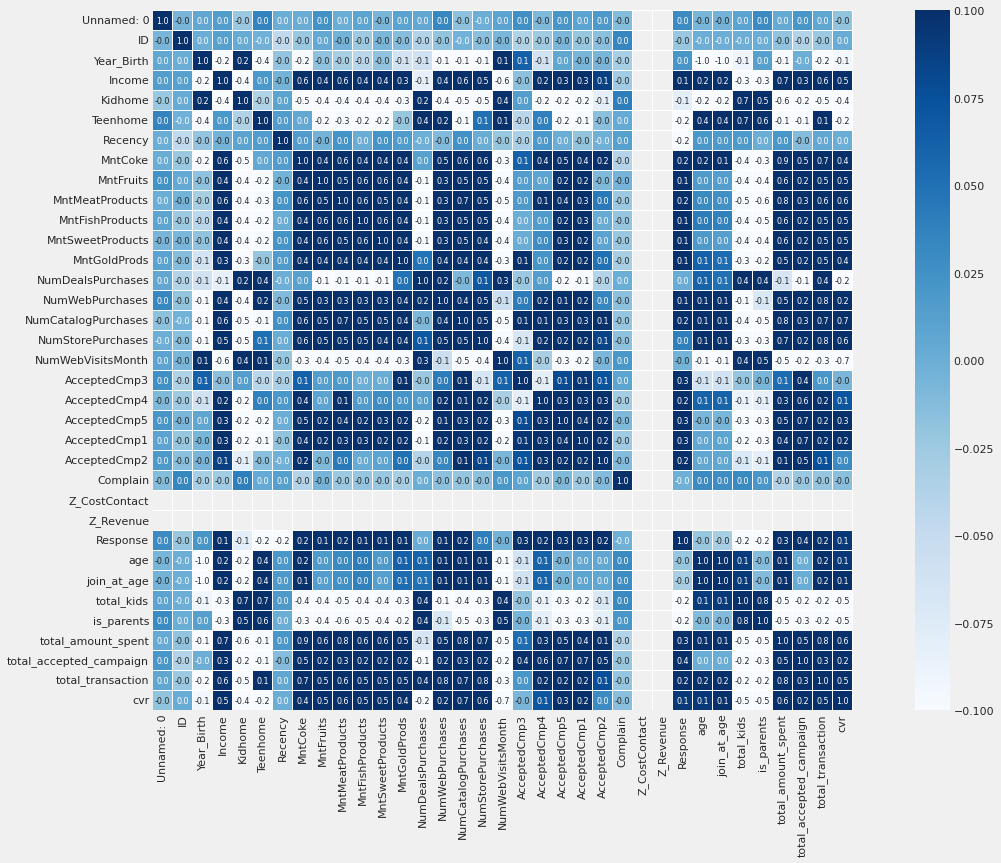

In [7]:
# correlation heatmap
plt.figure(figsize=(20, 12))
corrmat = dataset.corr()
sns.heatmap(corrmat, cmap='Blues', annot=True, fmt='.1f',
           vmin=corrmat.values.min(), vmax=1, square=True, linewidths=0.1, annot_kws={"fontsize":8})

#### Income vs. Spending

(0.0, 120000000.0)

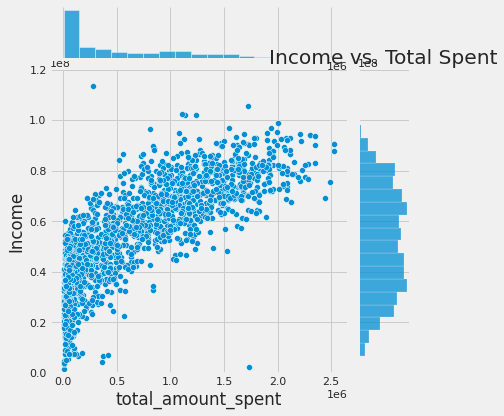

In [8]:
plot = sns.jointplot(x=dataset["total_amount_spent"], y=dataset["Income"])
plt.title('Income vs. Total Spent')
plot.ax_marg_y.set_ylim(0, 120000000)

(0.0, 120000000.0)

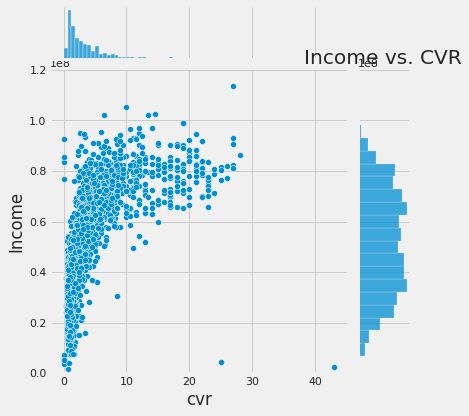

In [9]:
plot = sns.jointplot(x=dataset["cvr"], y=dataset["Income"])
plt.title('Income vs. CVR')
plot.ax_marg_y.set_ylim(0, 120000000)

#### Age vs. Spending & Income

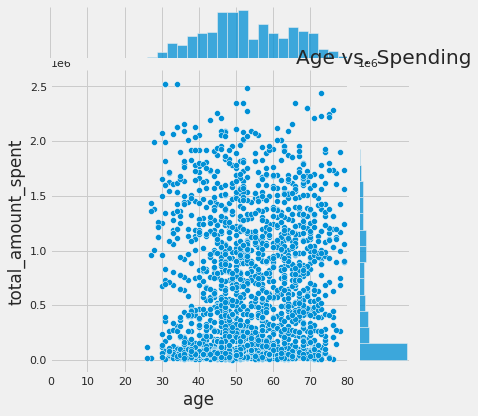

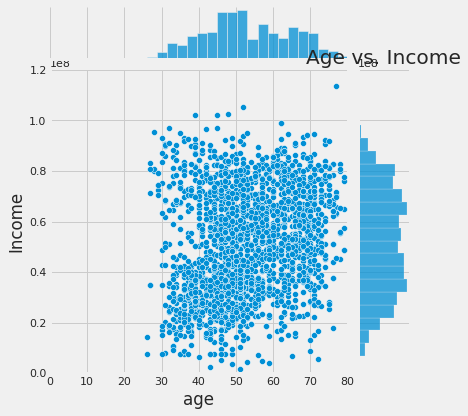

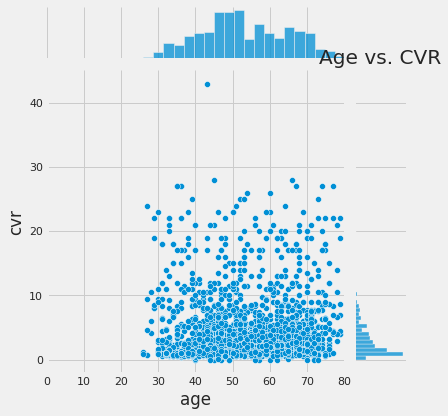

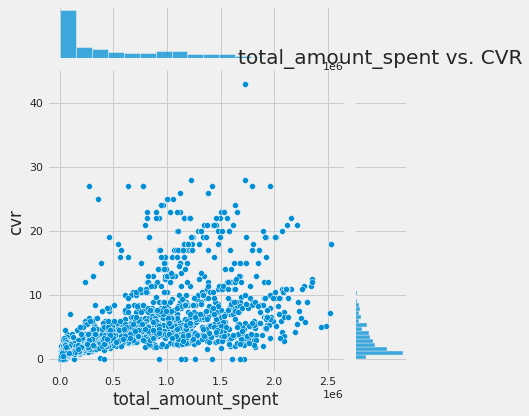

In [10]:
plot = sns.jointplot(x=dataset["age"], y=dataset["total_amount_spent"])
plt.title('Age vs. Spending')
plot.ax_marg_x.set_xlim(0, 80)
plt.show()

plot = sns.jointplot(x=dataset["age"], y=dataset["Income"])
plt.title('Age vs. Income')
plot.ax_marg_x.set_xlim(0, 80)
plot.ax_marg_y.set_ylim(0, 120000000)
plt.show()

plot = sns.jointplot(x=dataset["age"], y=dataset["cvr"])
plt.title('Age vs. CVR')
plot.ax_marg_x.set_xlim(0, 80)
plt.show()

plot = sns.jointplot(x=dataset["total_amount_spent"], y=dataset["cvr"])
plt.title('total_amount_spent vs. CVR')
# plot.ax_marg_x.set_xlim(0, 80)
plt.show()

# 3. Data Cleaning and Preprocessing

In [11]:
dataset.columns

Index(['Unnamed: 0', 'ID', 'Year_Birth', 'Education', 'Marital_Status',
       'Income', 'Kidhome', 'Teenhome', 'Dt_Customer', 'Recency', 'MntCoke',
       'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
       'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
       'AcceptedCmp2', 'Complain', 'Z_CostContact', 'Z_Revenue', 'Response',
       'age', 'join_at_age', 'total_kids', 'is_parents', 'Marital_condition',
       'age_range', 'total_amount_spent', 'total_accepted_campaign',
       'total_transaction', 'cvr'],
      dtype='object')

## A. Null Values

In [12]:
dataset.isna().sum()

Unnamed: 0                  0
ID                          0
Year_Birth                  0
Education                   0
Marital_Status              0
Income                     24
Kidhome                     0
Teenhome                    0
Dt_Customer                 0
Recency                     0
MntCoke                     0
MntFruits                   0
MntMeatProducts             0
MntFishProducts             0
MntSweetProducts            0
MntGoldProds                0
NumDealsPurchases           0
NumWebPurchases             0
NumCatalogPurchases         0
NumStorePurchases           0
NumWebVisitsMonth           0
AcceptedCmp3                0
AcceptedCmp4                0
AcceptedCmp5                0
AcceptedCmp1                0
AcceptedCmp2                0
Complain                    0
Z_CostContact               0
Z_Revenue                   0
Response                    0
age                         0
join_at_age                 0
total_kids                  0
is_parents

In [13]:
dataset = dataset.dropna()

## B. Duplicate Rows

In [14]:
dataset.duplicated().sum()

0

In [15]:
dataset.shape

(2216, 40)

We have no duplicate data here

### Feature Encoding

In [16]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2216 entries, 0 to 2239
Data columns (total 40 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Unnamed: 0               2216 non-null   int64         
 1   ID                       2216 non-null   int64         
 2   Year_Birth               2216 non-null   int64         
 3   Education                2216 non-null   object        
 4   Marital_Status           2216 non-null   object        
 5   Income                   2216 non-null   float64       
 6   Kidhome                  2216 non-null   int64         
 7   Teenhome                 2216 non-null   int64         
 8   Dt_Customer              2216 non-null   datetime64[ns]
 9   Recency                  2216 non-null   int64         
 10  MntCoke                  2216 non-null   int64         
 11  MntFruits                2216 non-null   int64         
 12  MntMeatProducts          2216 non-

In [17]:
# label encoder
mapping_education = {
    'SMA' : 0,
    'D3' : 1,
    'S1' : 2,
    'S2' : 3,
    'S3' : 4
}

dataset['Education_mapped'] = dataset['Education'].map(mapping_education)


In [18]:
dataset.drop(['Education', 'Marital_Status'], axis=1, inplace=True)

In [19]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2216 entries, 0 to 2239
Data columns (total 39 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Unnamed: 0               2216 non-null   int64         
 1   ID                       2216 non-null   int64         
 2   Year_Birth               2216 non-null   int64         
 3   Income                   2216 non-null   float64       
 4   Kidhome                  2216 non-null   int64         
 5   Teenhome                 2216 non-null   int64         
 6   Dt_Customer              2216 non-null   datetime64[ns]
 7   Recency                  2216 non-null   int64         
 8   MntCoke                  2216 non-null   int64         
 9   MntFruits                2216 non-null   int64         
 10  MntMeatProducts          2216 non-null   int64         
 11  MntFishProducts          2216 non-null   int64         
 12  MntSweetProducts         2216 non-

In [20]:
encoder_Marital = LabelBinarizer()

# Application of the LabelBinarizer
Marital_encoded = encoder_Marital.fit_transform(dataset.Marital_condition.values.reshape(-1,1))

# Insertion of the coded values into the original data set
dataset['Marital_encoded'] = Marital_encoded

# Delete the original column to avoid duplication
dataset = dataset.drop(['Marital_condition'], axis=1)

In [21]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2216 entries, 0 to 2239
Data columns (total 39 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Unnamed: 0               2216 non-null   int64         
 1   ID                       2216 non-null   int64         
 2   Year_Birth               2216 non-null   int64         
 3   Income                   2216 non-null   float64       
 4   Kidhome                  2216 non-null   int64         
 5   Teenhome                 2216 non-null   int64         
 6   Dt_Customer              2216 non-null   datetime64[ns]
 7   Recency                  2216 non-null   int64         
 8   MntCoke                  2216 non-null   int64         
 9   MntFruits                2216 non-null   int64         
 10  MntMeatProducts          2216 non-null   int64         
 11  MntFishProducts          2216 non-null   int64         
 12  MntSweetProducts         2216 non-

### Feature Standardization

In [22]:
dataset2 = dataset.drop(columns=['ID', 'Year_Birth', 'age_range', 'Dt_Customer'])

In [23]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc.fit(dataset2)
dataset_scaled = pd.DataFrame(sc.transform(dataset2), columns=dataset2.columns)
dataset_scaled

,Unnamed: 0,Income,Kidhome,Teenhome,Recency,MntCoke,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,...,age,join_at_age,total_kids,is_parents,total_amount_spent,total_accepted_campaign,total_transaction,cvr,Education_mapped,Marital_encoded
0,-1.744688,0.234063,-0.823039,-0.928972,0.310532,0.978226,1.549429,1.690227,2.454568,1.484827,...,0.986443,0.897752,-1.264803,-1.581389,1.675488,-0.439265,1.319446,-0.167630,-0.457733,1.348829
1,-1.743132,-0.234559,1.039938,0.909066,-0.380509,-0.872024,-0.637328,-0.717986,-0.651038,-0.633880,...,1.236801,1.313688,1.405806,0.632356,-0.962358,-0.439265,-1.157987,-0.652811,-0.457733,1.348829
2,-1.741577,0.769478,-0.823039,-0.928972,-0.795134,0.358511,0.569159,-0.178368,1.340203,-0.146821,...,0.318822,0.315443,-1.264803,-1.581389,0.280250,-0.439265,0.797881,0.175797,-0.457733,-0.741384
3,-1.740022,-1.017239,1.039938,-0.928972,-0.795134,-0.872024,-0.561922,-0.655551,-0.504892,-0.585174,...,-1.266777,-1.181925,0.070501,0.632356,-0.919224,-0.439265,-0.897205,-0.625532,-0.457733,-0.741384
4,-1.738467,0.240221,1.039938,-0.928972,1.554407,-0.391671,0.418348,-0.218505,0.152766,-0.000703,...,-1.016420,-0.932363,0.070501,0.632356,-0.307044,-0.439265,0.537099,-0.120865,1.533113,-0.741384
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2211,1.731104,0.356642,-0.823039,0.909066,-0.104093,1.197646,0.418348,0.066913,0.079693,2.215416,...,0.151917,0.149069,0.070501,0.632356,1.217598,-0.439265,0.406708,-0.161784,-0.457733,-0.741384
2212,1.732659,0.467539,2.902916,0.909066,0.241428,0.299208,-0.662463,-0.610954,-0.687574,-0.658233,...,1.904422,1.979184,2.741110,0.632356,-0.270546,1.033369,0.928273,-0.255313,1.533113,-0.741384
2213,1.734214,0.188091,-0.823039,-0.928972,1.450751,1.787710,0.544024,0.223001,-0.102990,-0.365998,...,-1.016420,-0.932363,-1.264803,-1.581389,1.051696,1.033369,0.537099,-0.250442,-0.457733,1.348829
2214,1.735769,0.675388,-0.823039,0.909066,-1.417072,0.364441,0.091591,0.209622,0.773887,0.072356,...,1.069896,1.147313,0.070501,0.632356,0.391404,-0.439265,1.058664,0.670234,0.537690,-0.741384


# Data Modeling : K-means clustering

KMeans

K-Means starts by randomly choosing the center point of k clusters, and the data points outside the center are included in the clusters they are similar to, according to their distance from the mean values of the clusters. Then, the average value of each cluster is calculated and new cluster centers are determined. Again, the distances of the objects from the center are examined. This process until the change is over.


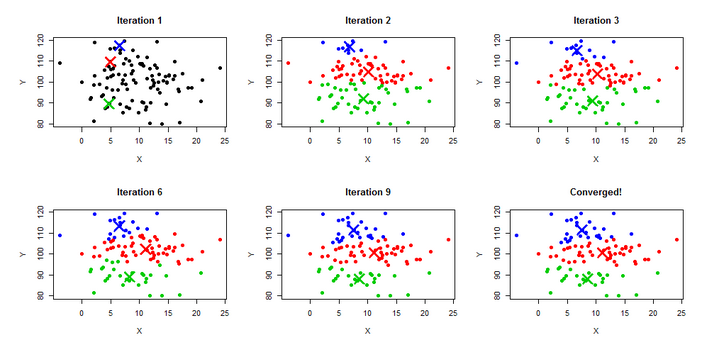

Source : Emre Yesilyurt, 2017

#### A. Determine Optimal Cluster
WCSS(Within Cluster Sum Of Square):

   

*   It is an indicator of how consistent the different cluster amounts are.
*   Calculates and sums the square of the distance of each sample from the cluster center.
* The smaller the inertia value, the more consistent the different clusters will be.
*  As the number of clusters increases, the WCSS value starts to decrease.
*  The inertia value and the optimal number of clusters are found by the Elbow method.


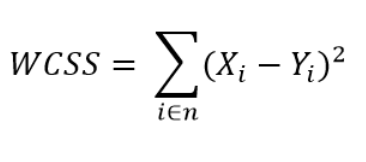

Text(0.5, 1.0, 'Elbow Method')

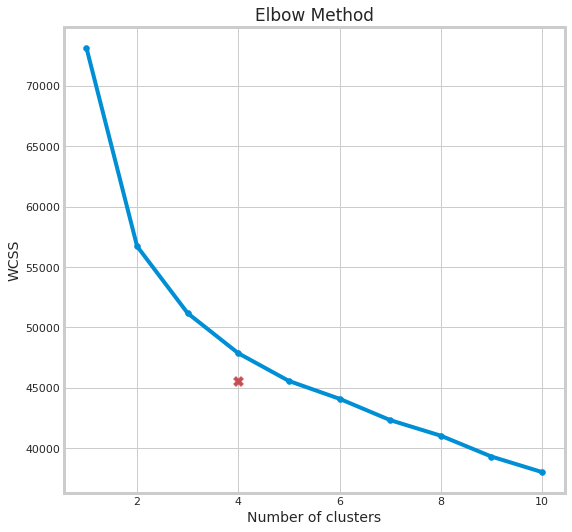

In [24]:
plt.rcParams['figure.figsize'] = [8,8]
sns.set_style("whitegrid")
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

inertia_list = []
for num_clusters in range(1, 11):
    kmeans_model = KMeans(n_clusters=num_clusters, init="k-means++")
    kmeans_model.fit(dataset_scaled)
    inertia_list.append(kmeans_model.inertia_)
    
#plotting the inertia curve
plt.plot(range(1,11),inertia_list)
plt.scatter(range(1,11),inertia_list)
plt.scatter(4, inertia_list[4], marker="X", s=100, c="r")
plt.xlabel("Number of clusters", size=14)
plt.ylabel("WCSS", size=14)
plt.title("Elbow Method", size=17)

In [25]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4, random_state=0)
kmeans.fit(dataset_scaled.values)
dataset_scaled['cluster'] = kmeans.labels_
dataset['cluster'] = kmeans.labels_

In [26]:
dataset_scaled.sample()

,Unnamed: 0,Income,Kidhome,Teenhome,Recency,MntCoke,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,...,join_at_age,total_kids,is_parents,total_amount_spent,total_accepted_campaign,total_transaction,cvr,Education_mapped,Marital_encoded,cluster
1493,0.60361,1.270364,-0.823039,-0.928972,-0.760582,0.382232,2.781051,1.039117,0.134498,2.678122,...,-1.514673,-1.264803,-1.581389,0.980358,-0.439265,0.406708,2.784379,-0.457733,-0.741384,2


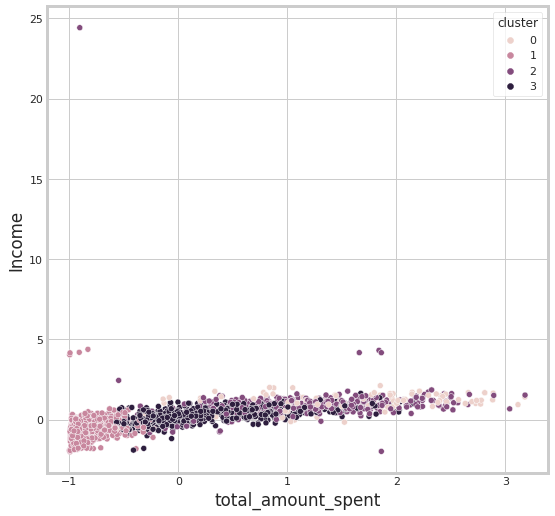

In [27]:
sns.scatterplot(data=dataset_scaled, x='total_amount_spent', y='Income', hue='cluster')
set_ylim = (-1,10)

# Customer personality analysis for marketing retargeting

## Cluster Analysis & Interpretation

### Statistical Summary per Cluster

In [28]:
numerical_features = ['Income', 'Kidhome', 'Teenhome', 'Recency', 'MntCoke', 
                      'MntFruits', 'MntMeatProducts', 'MntFishProducts', 
                      'MntSweetProducts', 'MntGoldProds', 'NumDealsPurchases',
                      'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases',
                      'NumWebVisitsMonth', 'Z_CostContact', 'Z_Revenue',
                      'age', 'join_at_age', 'total_kids', 'total_amount_spent'
                     ]
numerical_features

['Income',
 'Kidhome',
 'Teenhome',
 'Recency',
 'MntCoke',
 'MntFruits',
 'MntMeatProducts',
 'MntFishProducts',
 'MntSweetProducts',
 'MntGoldProds',
 'NumDealsPurchases',
 'NumWebPurchases',
 'NumCatalogPurchases',
 'NumStorePurchases',
 'NumWebVisitsMonth',
 'Z_CostContact',
 'Z_Revenue',
 'age',
 'join_at_age',
 'total_kids',
 'total_amount_spent']

In [29]:
dataset[numerical_features+['cluster']].groupby('cluster')['Income','total_amount_spent'].describe()

Income                                                      \
          count          mean           std         min         25%   
cluster                                                               
0         130.0  8.008058e+07  1.178553e+07  37929000.0  74075500.0   
1        1047.0  3.513861e+07  1.442704e+07   1730000.0  26079000.0   
2         428.0  7.578974e+07  3.150868e+07   2447000.0  68691750.0   
3         611.0  5.915106e+07  1.075358e+07   4428000.0  52682000.0   

                                             total_amount_spent                \
                50%         75%          max              count          mean   
cluster                                                                         
0        81751500.0  87771000.0  105471000.0              130.0  1.577823e+06   
1        34633000.0  42701500.0  162397000.0             1047.0  1.012999e+05   
2        74998500.0  81168250.0  666666000.0              428.0  1.304000e+06   
3        59594000.0  66012000.0   93404000.0              611.0  7.790327e+05   

                                                                              
                   std       min        25%        50%        75%        max  
cluster                                                                       
0        454646.390669  265000.0  1302250.0  1631000.0  1865750.0  2524000.0  
1         92308.112322    5000.0    38500.0    65000.0   136000.0   473000.0  
2        420366.256052   62000.0  1002500.0  1285500.0  1587250.0  2525000.0  
3        357153.521992  232000.0   487000.0   724000.0  1006500.0  2092000.0

In [30]:
map_cluster = {
    0 : 'Low Spender',
    1 : 'Risk of Churn',
    2 : 'Mid Spender',
    3 : 'High Spender'
}

dataset['cluster_mapped'] = dataset['cluster'].map(map_cluster)

(array([0, 1, 2, 3]), <a list of 4 Text major ticklabel objects>)

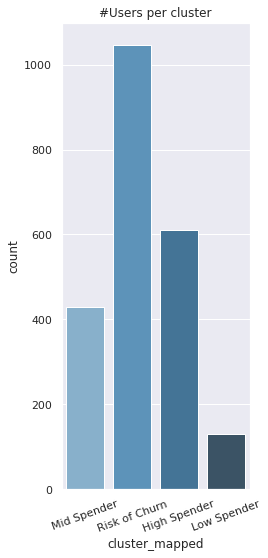

In [31]:
sns.set(rc={'figure.figsize':(3,8)})
sns.countplot(x=dataset['cluster_mapped'], palette='Blues_d')
plt.title('#Users per cluster')
plt.xticks(rotation=20)

(0.0, 120000000.0)

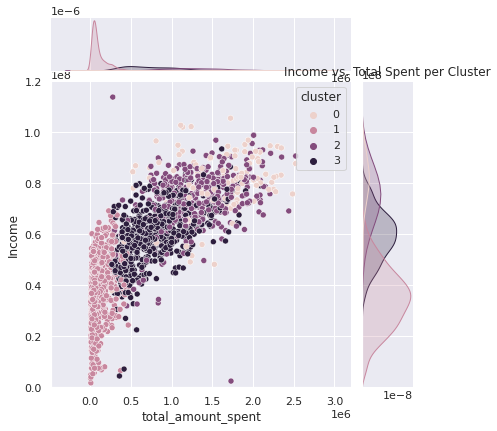

In [32]:
plot = sns.jointplot(x=dataset["total_amount_spent"], y=dataset["Income"], hue=dataset["cluster"])
plt.title('Income vs. Total Spent per Cluster')
plot.ax_marg_y.set_ylim(0, 120000000)

### Total Income per Cluster

(0.0, 120000000.0)

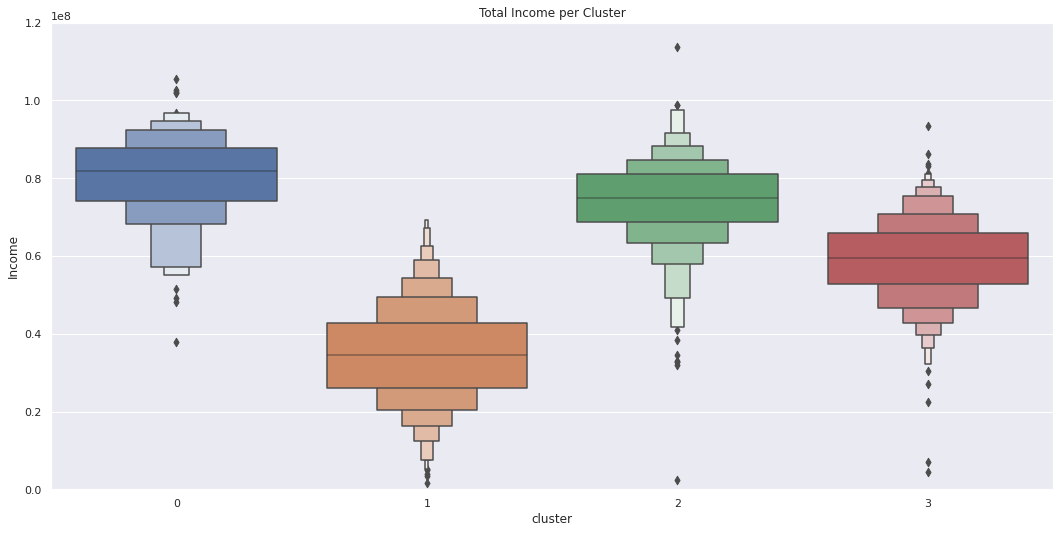

In [33]:
sns.set(rc={'figure.figsize':(16,8)})
sns.boxenplot(x=dataset['cluster'], y=dataset['Income'])
plt.title('Total Income per Cluster')
plt.ylim(0, 120000000)

### Total Spending per Cluster

Text(0.5, 1.0, 'Total Amount Spent per Cluster')

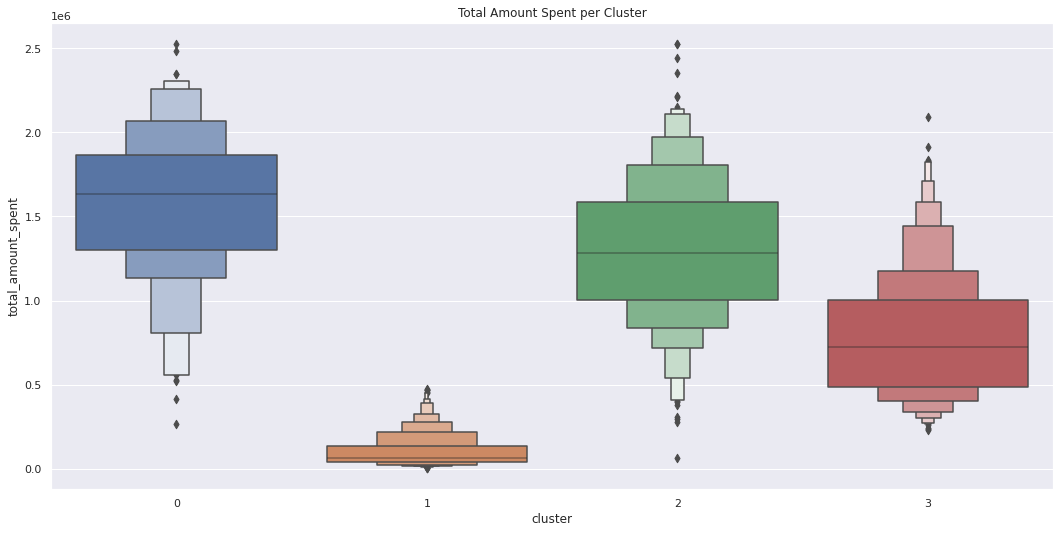

In [34]:
sns.set(rc={'figure.figsize':(16,8)})
sns.boxenplot(x=dataset['cluster'], y=dataset['total_amount_spent'])
plt.title('Total Amount Spent per Cluster')

Cluster 1 and 2 spent the highest respectively

### Total Visits per Cluster

Text(0.5, 1.0, 'Total Visit Web per Cluster')

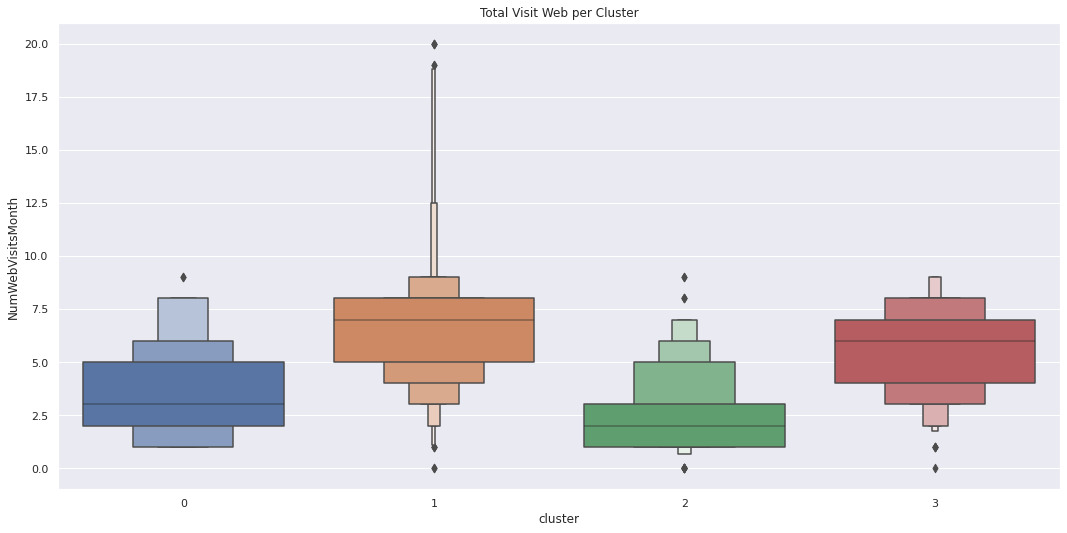

In [35]:
sns.set(rc={'figure.figsize':(16,8)})
sns.boxenplot(x=dataset['cluster'], y=dataset['NumWebVisitsMonth'])
plt.title('Total Visit Web per Cluster')

### Deal Puchased per Cluster

Text(0.5, 1.0, 'Deal Puchased per Cluster')

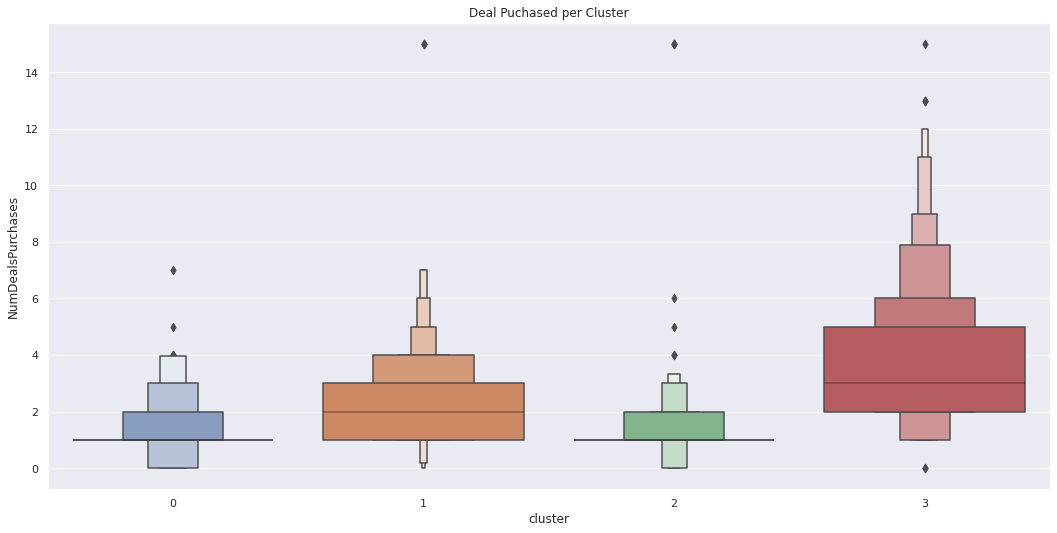

In [36]:
sns.set(rc={'figure.figsize':(16,8)})
sns.boxenplot(x=dataset['cluster'], y=dataset['NumDealsPurchases'])
plt.title('Deal Puchased per Cluster')

### Conversion per Cluster

Text(0.5, 1.0, 'CVR per Cluster')

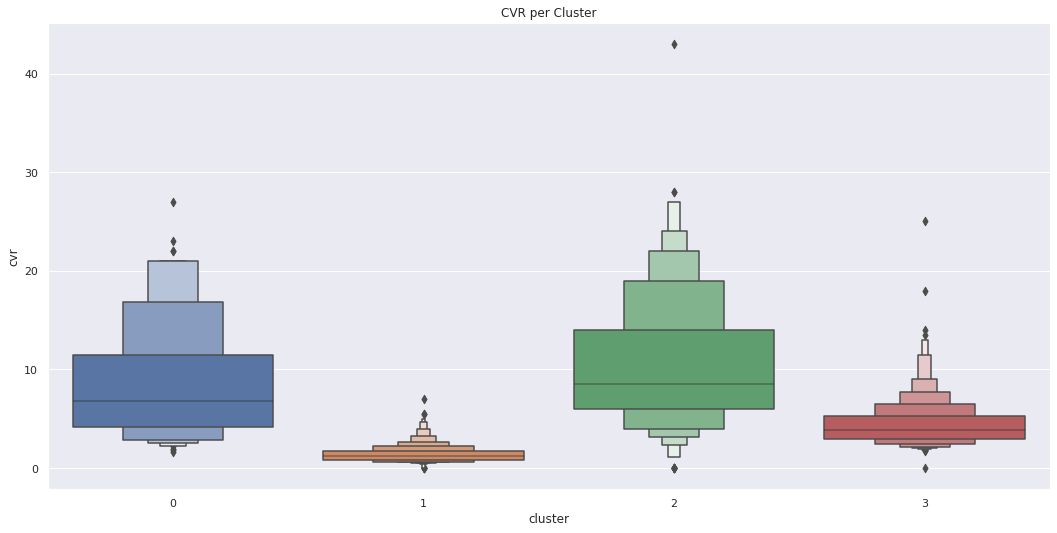

In [37]:
sns.set(rc={'figure.figsize':(16,8)})
sns.boxenplot(x=dataset['cluster'], y=dataset['cvr'])
plt.title('CVR per Cluster')